$$
\textbf{Music Generation Project: Finishing the Unfinished Symphony}
$$

$$
\textbf{Model 1: LSTM}
$$

$$
\text{Realized by: Jebali Wafa and Belanez Hamdi}
$$

#### **Introduction**
This project explores the use of Long Short-Term Memory (LSTM) networks to generate music. The LSTM model is used to learn patterns in musical sequences and generate new music based on an input seed, such as existing notes, offsets, and durations.

#### **Model Description**
The LSTM model consists of multiple layers of LSTM units, designed to capture long-range dependencies in musical data. It takes a sequence of musical elements (notes, offsets, durations) and learns their patterns to generate new sequences. The model can be trained on different musical compositions and then used to generate new pieces that continue or complement the input seed.

#### **Conclusion**
Using LSTM networks for music generation proves to be an effective approach for creating coherent and creative musical compositions. This project successfully generates music that continues the theme of the unfinished symphony by learning from past musical patterns.


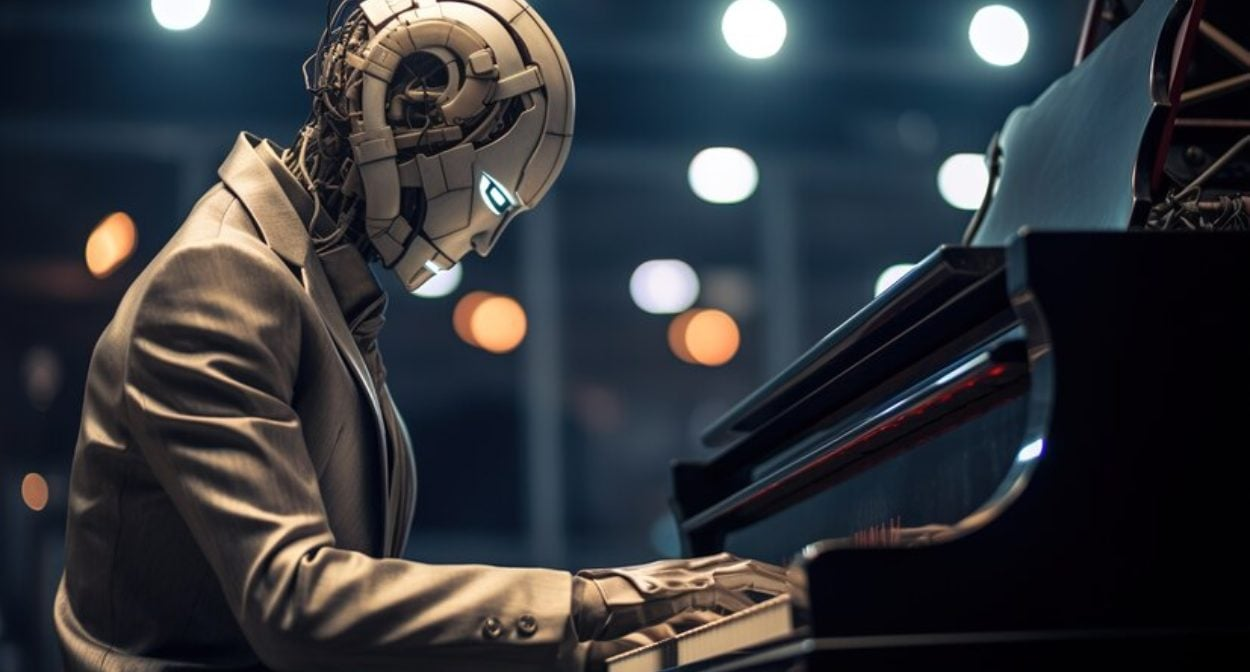

##1. Mount Drive to load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##2. Library Imports

In [2]:
!pip install music21

In [3]:
#import statements
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream, duration
import glob
import gc
from itertools import chain
import copy
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
#from keras.layers import CuDNNLSTM,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from numpy import argmax
from fractions import Fraction
import random
import keras.utils

##3. MIDI Data Extraction Function (data_extractor)
This function processes MIDI files and extracts metadata:

* **notes**: The pitch of individual notes or chords.
* **durations**: The length of each musical element.
* **offsets**: The difference between the start times of consecutive notes.

The function ensures flexibility to handle both instrument-specific data and flat structures when instruments aren't explicitly defined. This step is essential for preparing raw music data into a format usable by machine learning models.

In [4]:
def data_extractor(directory):
  notes = []
  offsets = []
  durations = []
  for file in glob.glob(directory):
          mid = converter.parse(file)
          notes_to_parse = None
          prev_offset = 0

          try:
              s2 = instrument.partitionByInstrument(mid)
              notes_to_parse = s2.parts[0].recurse()

          except:
              notes_to_parse = mid.flat.notes

          for i,element in enumerate(notes_to_parse):
              if isinstance(element, note.Note):
                  notes.append(str(element.pitch))

                  durations.append(str(element.quarterLength))

                  offset_dif = float(element.offset-prev_offset)

                  offsets.append(round(offset_dif,3))
                  prev_offset = element.offset


              elif isinstance(element, chord.Chord):
                  notes.append('.'.join(str(n) for n in element.normalOrder))
                  offset_dif = float(element.offset-prev_offset)

                  durations.append(str(element.quarterLength))

                  offsets.append(round(offset_dif,3))
                  prev_offset = element.offset

  return [notes,offsets,durations]

##4.  Loading Training and Seed Data
* **Training Data**: Extracted from a directory of MIDI files for model training.
* **Seed Data**: Extracted separately to help the model generate music sequences later.



In [5]:
# Reading in training data
data = data_extractor("/content/drive/MyDrive/Music_Gen_Data/input/*.mid")
note_data = data[0]
offset_data = data[1]
duration_data = data[2]

# Reading in seed data
seed_data = data_extractor("/content/drive/MyDrive/Music_Gen_Data/seed/*.mid")
note_seed = seed_data[0]
offset_seed = seed_data[1]
duration_seed = seed_data[2]

/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2009 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2010 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2004 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEve

##5.     Creating a Unique Vocabulary
The unique vocabulary identifies all distinct notes, offsets, and durations across both training and seed data.

This is important for encoding the data and ensuring consistency during the model's learning process.

In [6]:
# Combine the training data and seed data to create a general vocabulary
unique_notes = sorted(list(set(note_seed + note_data)))  # Merge seed and training note data
unique_offsets = sorted(list(set(offset_seed + offset_data)))  # Merge seed and training offset data
unique_durations = sorted(list(set(duration_seed + duration_data)))  # Merge seed and training duration data

# the number of unique items in the combined vocabulary
unique_note_number = len(unique_notes)
unique_offset_number = len(unique_offsets)
unique_duration_number = len(unique_durations)

# Debug prints to confirm the combined vocabularies
print(f"Unique Notes: {unique_note_number}, Unique Offsets: {unique_offset_number}, Unique Durations: {unique_duration_number}")

Unique Notes: 251, Unique Offsets: 192, Unique Durations: 295


##6. Data Encoding and Decoding Functions
Two functions, one_hot_encode and one_hot_decode, transform data between raw and one-hot encoded formats:

* **Encoding**: Converts categorical data (notes, offsets, durations) into binary vectors for input to the model.
* **Decoding**: Reverses the encoding to interpret the model's predictions.
These transformations are essential for training the model and generating predictions in a meaningful way.

In [7]:
def one_hot_encode(vector, all_values):
  encoded_vectors = []
  int_to_index = dict((c, i) for i, c in enumerate(all_values))
  for i in vector:
    zero = [0]*(len(all_values)-1)
    zero.insert(int_to_index[i],1)
    encoded_vectors.append(zero)

  return encoded_vectors

In [8]:
def one_hot_decode(vector,all_values):
  decoded_vector = []
  index_to_int = dict((i, c) for i, c in enumerate(all_values))
  decoded_vector.append(index_to_int[argmax(vector)])
  return decoded_vector

##7. Segmenting the Data for Training (make_segments)
This function splits the musical data into fixed-length sequences for input into the LSTM model. Each segment consists of:

* **Input Sequence**: A sequence of notes, offsets, or durations.
* **Output Sequence**: The next element the model should predict.

This segmentation approach is tailored for our sequential dataset and differs from the standard **70-30 train-test split**. **Traditional splitting** disrupts dependencies within sequential data, such as music, where each element relies on prior context. **Instead**, we divide the dataset into overlapping, fixed-length segments: an input sequence and its corresponding output element. This ensures the model captures temporal dependencies critical for generating coherent sequences. While segmentation prepares the data, train-test splitting can still be applied afterward, preserving the structure essential for effective learning.
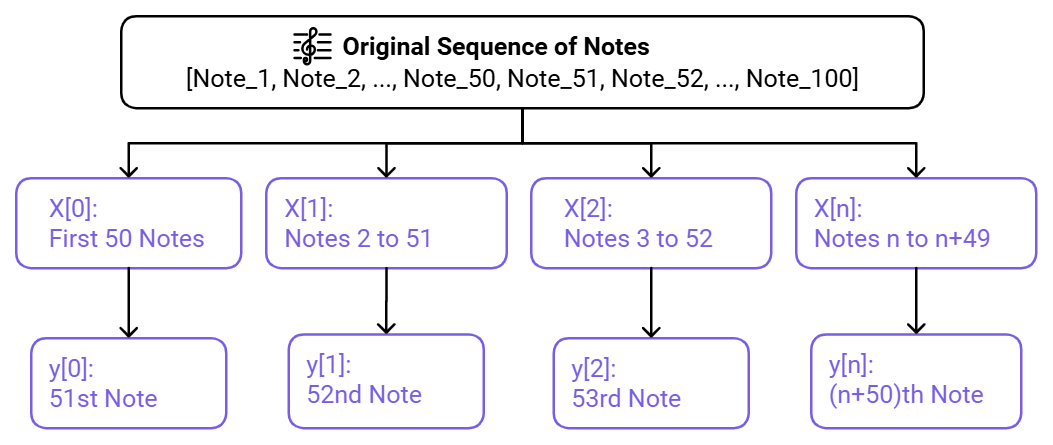


In [9]:
segment_length = 64
def make_segments(data_array,unique_values, seq_length = segment_length):
  input_seq = []
  output_seq = []

  processed_data = one_hot_encode(data_array,unique_values)

  for i in range(0,len(processed_data) - seq_length,1):
    input_seq.append([processed_data[i:i+seq_length]])
    output_seq.append(processed_data[seq_length + i])

  del processed_data;gc.collect()

  input_seq = np.reshape(input_seq,(len(input_seq), segment_length,len(unique_values)))
  output_seq = np.array(output_seq)

  return input_seq, output_seq

In [10]:
#making segments for notes, offsets, and durations and garabge collecting unused varaibles to get RAM back
note_model_data = make_segments(data_array = note_data, unique_values = unique_notes)
offset_model_data = make_segments(data_array = offset_data, unique_values = unique_offsets)
duration_model_data = make_segments(data_array = duration_data, unique_values = unique_durations)


In [11]:
#splitting notes, offsets, and durations into training and testing data
X_train_note, X_test_note, y_train_note, y_test_note = train_test_split(note_model_data[0], note_model_data[1],test_size=0.2)
X_train_off, X_test_off, y_train_off, y_test_off = train_test_split(offset_model_data[0], offset_model_data[1],test_size=0.2)
X_train_dur, X_test_dur, y_train_dur, y_test_dur = train_test_split(duration_model_data[0], duration_model_data[1],test_size=0.2)

##8. Seed Preparation

In [12]:
# Filter seed data: only keep valid notes, offsets, and durations present in the training vocab
note_seed = [note for note in note_seed if note in unique_notes]
offset_seed = [offset for offset in offset_seed if offset in unique_offsets]
duration_seed = [duration for duration in duration_seed if duration in unique_durations]

# Perform one-hot encoding using the training vocab
note_seed = one_hot_encode(note_seed, unique_notes)
offset_seed = one_hot_encode(offset_seed, unique_offsets)
duration_seed = one_hot_encode(duration_seed, unique_durations)

##9. LSTM Model Definition (make_model)
The LSTM model architecture is defined with:

* **Input Layer**: Takes sequences of notes, offsets, or durations.
* **LSTM Layer**: Captures temporal dependencies in the music.
* **Dense Layers**: Reduce dimensions and produce probabilities for the output.
* **Dropout**: Prevents overfitting by randomly ignoring some neurons during training.

* **Activation Functions:**
  *   **tanh**: Used in LSTM gates for regulating information flow and capturing long-term dependencies.
  * **softmax**: In the output layer to predict the most likely next note, offset, or duration.
* **Optimizer**:

  * **Adam**: An adaptive optimizer that adjusts the learning rate for faster convergence and effective learning.
* **Loss Function**:

  * **Categorical Crossentropy**: Measures the difference between the predicted and actual class distributions, guiding the model's learning in multi-class classification tasks.

This architecture is well-suited for sequential data like music, where context is important.

In [13]:
def make_model(input_shape,output_shape):

  model = Sequential()
  model.add(LSTM(512,input_shape=input_shape,return_sequences=False))
  model.add(Dropout(0.25))
  model.add(Dense(128))
  model.add(Dense(output_shape,activation = 'softmax'))

  model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(learning_rate = .001),
      metrics=['accuracy']
  )
  return model

In [14]:
#makes note, offset, and duration model objects
model_notes = make_model(input_shape = (segment_length,unique_note_number), output_shape = unique_note_number)
model_offsets = make_model(input_shape = (segment_length,unique_offset_number), output_shape = unique_offset_number)
model_durations = make_model(input_shape = (segment_length,unique_duration_number), output_shape = unique_duration_number)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model_notes.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 512)                 │       1,564,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,715 (6.34 MB)

 Trainable params: 1,662,715 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model_offsets.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 512)                 │       1,443,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 192)                 │          24,768 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,534,272 (5.85 MB)

 Trainable params: 1,534,272 (5.85 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_durations.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 512)                 │       1,654,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 295)                 │          38,055 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,758,503 (6.71 MB)

 Trainable params: 1,758,503 (6.71 MB)

 Non-trainable params: 0 (0.00 B)

##10. Model Training

We trained separate models for notes, offsets, and durations because each represents distinct musical characteristics that contribute to the overall quality of generated sequences.

* **Notes Model**: Focuses on predicting the sequence of musical pitches, which is central to melody generation.
* **Offsets Model**: Handles the timing between successive notes, ensuring realistic rhythm and spacing.
* **Durations Model**: Determines how long each note is held, contributing to expressiveness and flow.

By training each model individually, we allow specialization, enabling each to focus exclusively on capturing the patterns and complexities of its respective feature. This approach reduces the risk of one feature overpowering or influencing another and ensures better overall performance in music generation.

**Early Stopping**: Stops training when the model stops improving, saving computational resources.


In [18]:
#defines callabcks for training
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=4)]

In [19]:
#fits the note model to train data
history_note = model_notes.fit(X_train_note,y_train_note,epochs=50, validation_split = 0.2, callbacks = my_callbacks)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.0476 - loss: 5.0088 - val_accuracy: 0.0829 - val_loss: 4.1324
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1099 - loss: 4.0450 - val_accuracy: 0.1276 - val_loss: 3.8340
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1317 - loss: 3.7100 - val_accuracy: 0.1763 - val_loss: 3.5003
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1903 - loss: 3.3085 - val_accuracy: 0.1974 - val_loss: 3.3528
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2085 - loss: 3.1191 - val_accuracy: 0.2211 - val_loss: 3.2065
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2347 - loss: 2.9033 - val_accuracy: 0.2211 - val_loss: 3.0859
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2747 - loss: 2.7247 - val_accuracy: 0.2605 - val_loss: 2.8938
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2914 - loss: 2.6001 - val_accuracy: 0.2816 - v

In [20]:
#fits the offset model to train data
history_offset = model_offsets.fit(X_train_off,y_train_off,epochs=50, validation_split = 0.2,callbacks = my_callbacks)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.3331 - loss: 2.5200 - val_accuracy: 0.5197 - val_loss: 1.3760
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4911 - loss: 1.4370 - val_accuracy: 0.5566 - val_loss: 1.2203
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5708 - loss: 1.1814 - val_accuracy: 0.6303 - val_loss: 1.0501
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6017 - loss: 1.1956 - val_accuracy: 0.6000 - val_loss: 1.1535
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6002 - loss: 1.1112 - val_accuracy: 0.6592 - val_loss: 0.9364
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6466 - loss: 0.9716 - val_accuracy: 0.6697 - val_loss: 0.9313
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6649 - loss: 0.9273 - val_accuracy: 0.6724 - val_loss: 0.9132
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6724 - loss: 0.9232 - val_accuracy: 0.6882 - v

In [21]:
#fits the duration model to train data
history_duration = model_durations.fit(X_train_dur,y_train_dur,epochs=50, validation_split = 0.2,callbacks = my_callbacks)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2288 - loss: 3.4514 - val_accuracy: 0.3737 - val_loss: 1.8829
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4367 - loss: 1.8534 - val_accuracy: 0.4197 - val_loss: 1.8029
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4848 - loss: 1.6937 - val_accuracy: 0.5553 - val_loss: 1.4285
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5719 - loss: 1.3639 - val_accuracy: 0.5842 - val_loss: 1.3062


##11. Visualizing Model Performance
Plots are created to visualize:

* **Accuracy**: How well the model predicts the correct outputs.
* **Loss**: How far off the predictions are from the actual values.

These graphs help diagnose issues like overfitting (if validation performance is much worse than training performance) or underfitting (if both performances are poor).

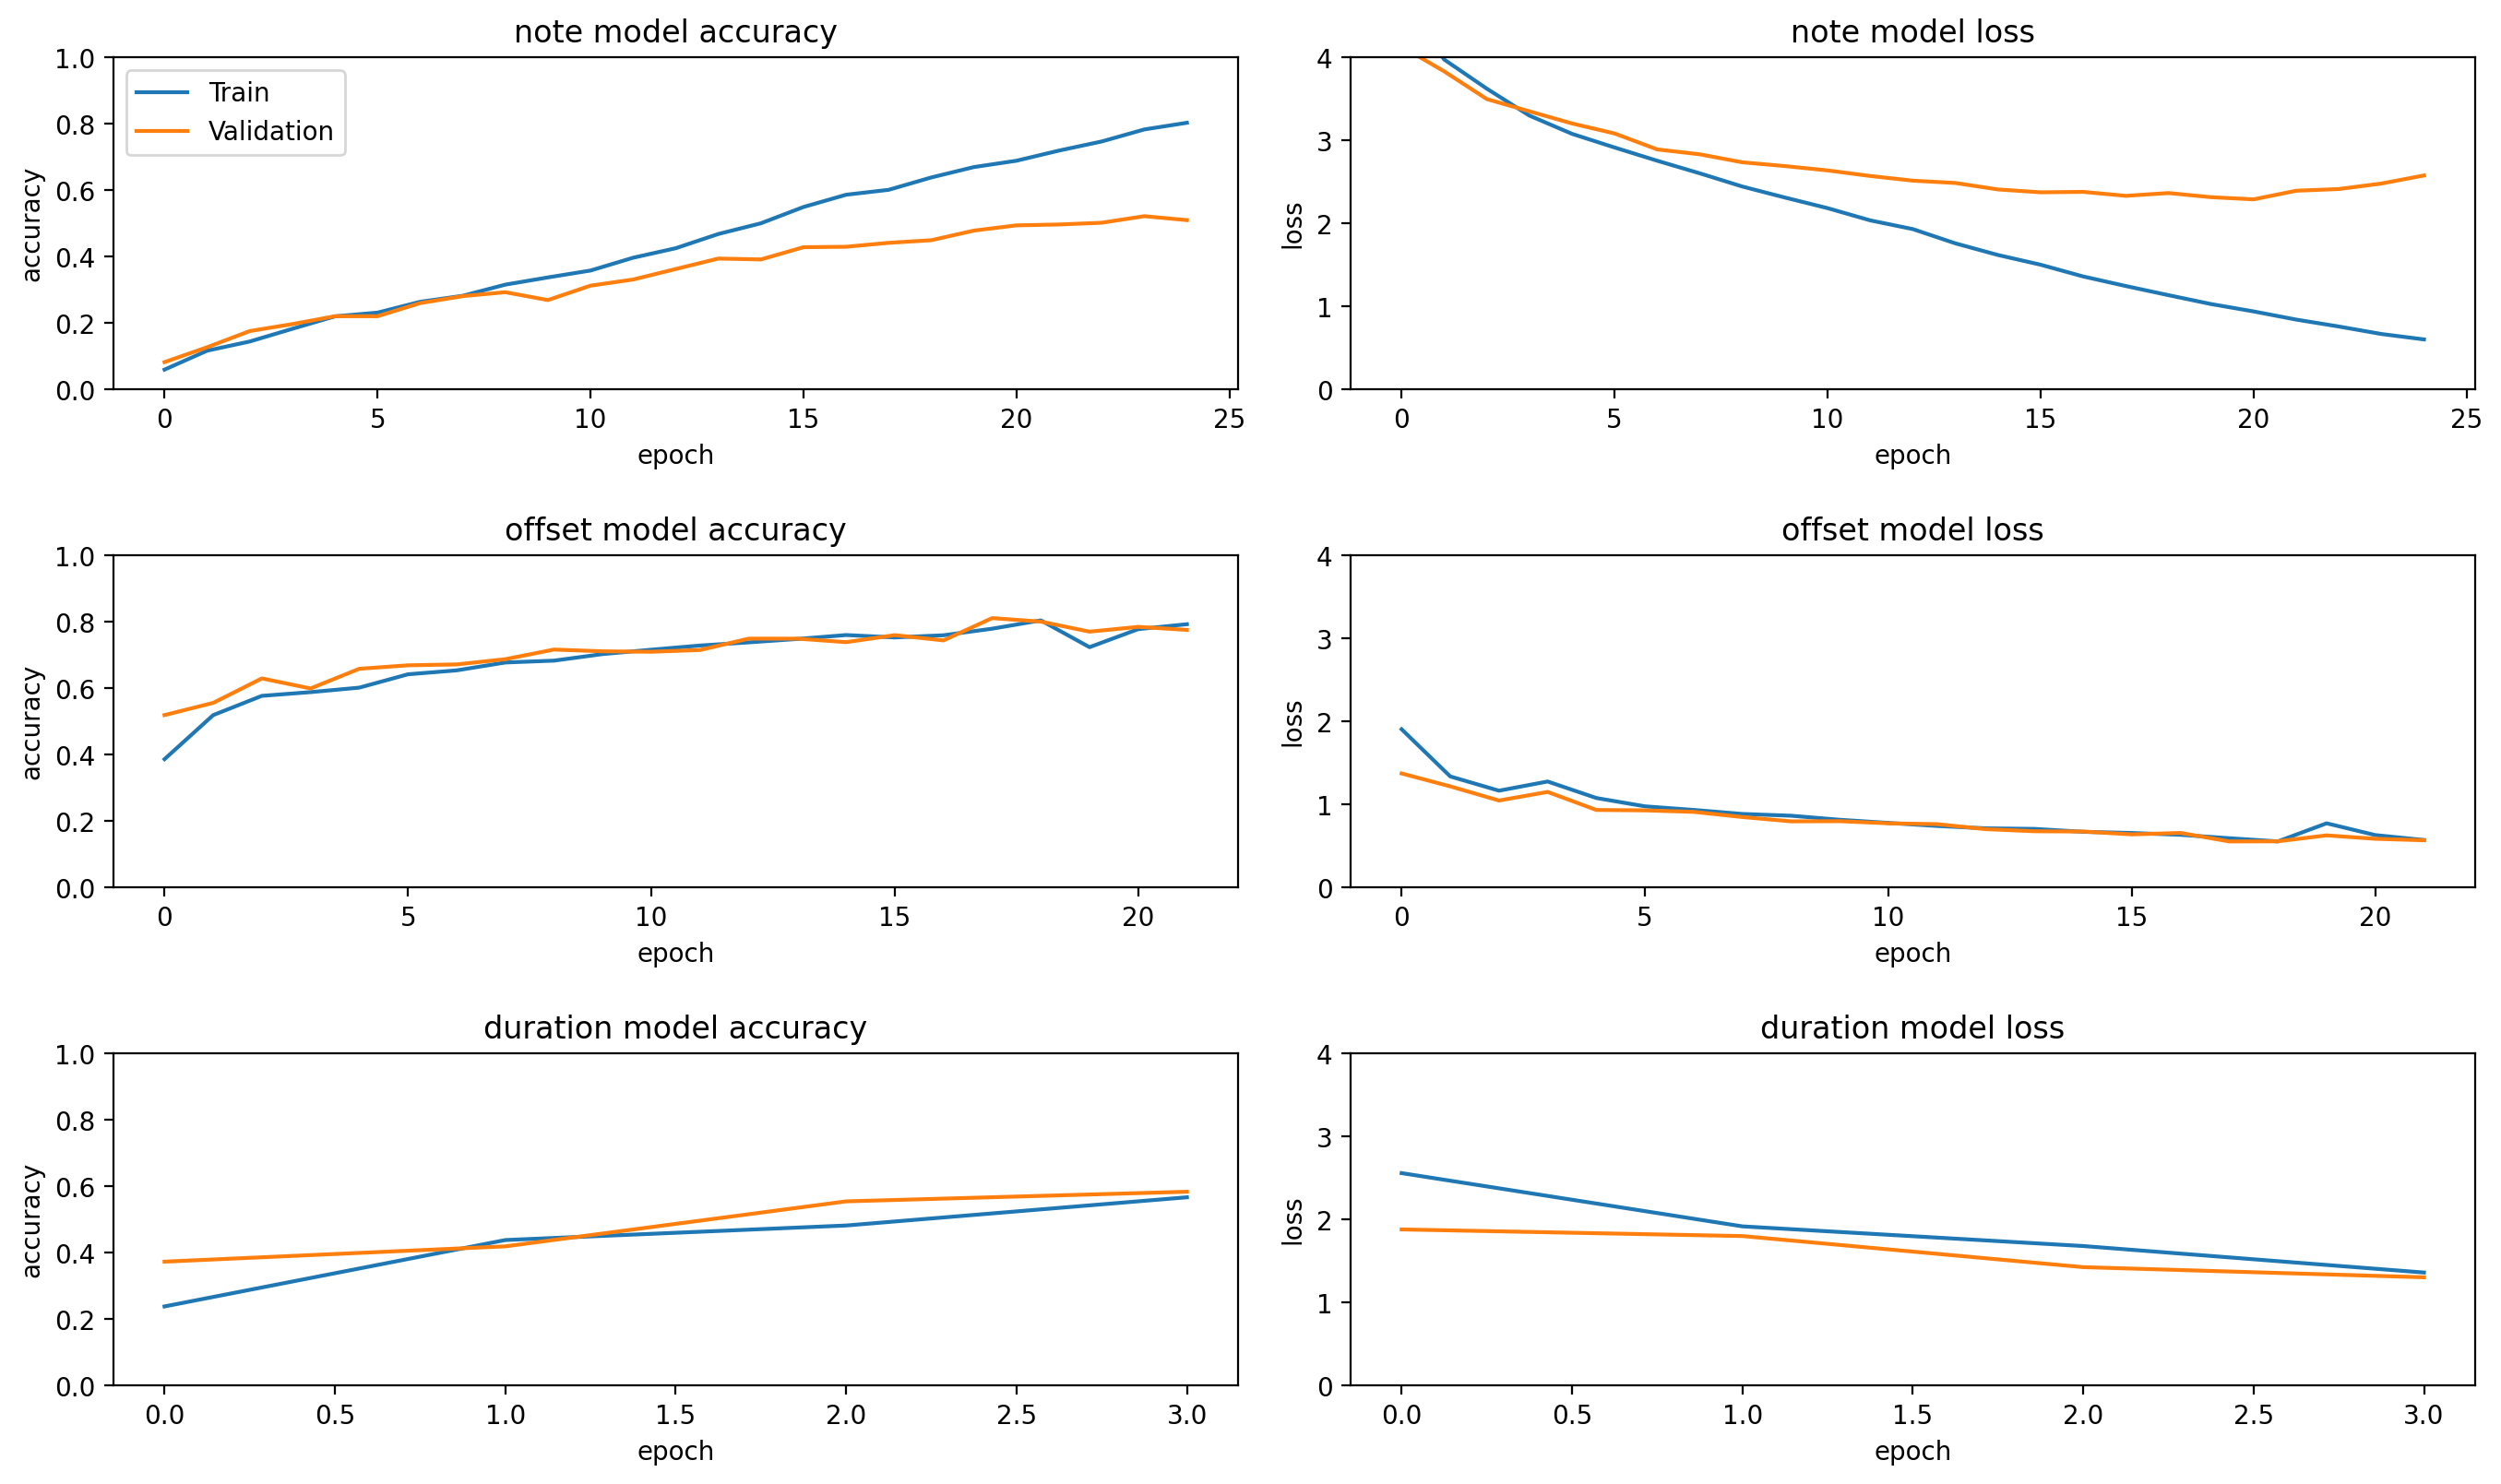

In [22]:
#plotting model results
plt.subplot(3,2,1)
plt.plot(history_note.history['accuracy']);plt.plot(history_note.history['val_accuracy']);plt.title('note model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch');plt.legend(['Train', 'Validation'], loc='upper left');plt.ylim(0,1)
plt.subplot(3,2,2)
plt.plot(history_note.history['loss']);plt.plot(history_note.history['val_loss']);plt.title('note model loss');plt.ylabel('loss');plt.xlabel('epoch');plt.ylim(0,4)
plt.subplot(3,2,3)
plt.plot(history_offset.history['accuracy']);plt.plot(history_offset.history['val_accuracy']);plt.title('offset model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch');plt.ylim(0,1)
plt.subplot(3,2,4)
plt.plot(history_offset.history['loss']);plt.plot(history_offset.history['val_loss']);plt.title('offset model loss');plt.ylabel('loss');plt.xlabel('epoch');plt.ylim(0,4)
plt.subplot(3,2,5)
plt.plot(history_duration.history['accuracy']);plt.plot(history_duration.history['val_accuracy']);plt.title('duration model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch');plt.ylim(0,1)
plt.subplot(3,2,6)
plt.plot(history_duration.history['loss']);plt.plot(history_duration.history['val_loss']);plt.title('duration model loss');plt.ylabel('loss');plt.xlabel('epoch');plt.ylim(0,4)
plt.subplots_adjust(left=0,
                    bottom=0,
                    right=2.0,
                    top=1.5,
                    wspace=0.1,
                    hspace=0.5)


##12. Generating Music
The process of music generation involves using a seed sequence (e.g., notes, offsets, durations) to iteratively generate new musical content. The **music_maker function **uses a trained model to predict the next element in the sequence, and the sample function controls the randomness of these predictions through a temperature parameter. The seed sequence is initially encoded as one-hot vectors, and the model generates the next values one by one. These predictions are diversified using the **sample function**, which modifies the probability distribution before selecting the next value, adding variability. The generated values are appended to the music sequence and decoded back to their original representation. This process continues until the desired number of notes is generated. The** music_maker function** is applied separately for notes, offsets, and durations, with varying diversity levels to control the randomness for each type of data.

In [23]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)
    preds = preds / np.sum(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [24]:
def music_maker(seed_vec, model_type, number_unique, unique, diversity, num_notes = 100):
  music = []
  arr = np.zeros((len(seed_vec)+num_notes,number_unique))
  for c,i in enumerate(seed_vec):
    arr[c] = i

  for i in range(0,num_notes,1):
    d_arr = np.zeros(number_unique)
    pred = model_type.predict(np.reshape(arr[i:len(arr)-num_notes+i], (1, len(arr[i:len(arr)-num_notes+i]),number_unique)),verbose = 0)[0]
    diverse = sample(pred, diversity)
    d_arr[diverse] = 1
    music.append(one_hot_decode(d_arr,all_values = unique)[0])

    arr[len(seed_vec)+i] = d_arr

  return music

In [25]:
# Use the music_maker function to generate music from the seed
generated_music_note = music_maker(note_seed, model_notes, unique_note_number, unique_notes, 0.7)
generated_music_offset = music_maker(offset_seed, model_offsets, unique_offset_number, unique_offsets, 0.7)
generated_music_duration = music_maker(duration_seed, model_durations, unique_duration_number, unique_durations, 0.2)

##13 Converting Generated Music to MIDI (to_midi Function):

Converts the generated music (notes, offsets, and durations) into a MIDI file using the Music21 library.

In [26]:
def to_midi(notes, offsets, durations):
  offset = offsets[0]
  s = stream.Stream()
  for i,ele in enumerate(notes):
    if ele[0].isalpha():
      n = note.Note(ele)
      try:
        n.quarterLength = float(durations[i])
      except:
        n.quarterLength = Fraction(durations[i])

      s.insert(offset,n)

      offset += offsets[i]
    else:
      chords = list(map(int,ele.split('.')))
      c = chord.Chord(chords)

      try:
        c.quarterLength = float(durations[i])
      except:
        c.quarterLength = Fraction(durations[i])

      s.insert(offset,c)

      offset += offsets[i]
  return s

In [27]:
#converts the generated music to a midi file
to_midi(generated_music_note,generated_music_offset, generated_music_duration).write('midi', "generated_LSTM.mid")


'generated_LSTM.mid'